> Tip: Use a virtual environment for clean dependencies.
>
> 1. Create venv (bash): `python3 -m venv .venv && source .venv/bin/activate`
> 2. Install deps: `pip install -r requirements.txt`
> 3. In VS Code, select the `.venv` interpreter so this notebook uses it.

# CHDP Notebook: Breast Cancer & Heart Disease Prediction

This notebook implements an end-to-end workflow with minimal folders (`data/`, `artifacts/`). Use this to prototype EDA, preprocessing, training, evaluation, and explainability. A separate Streamlit app provides a form-based UI for interactive predictions.

## 1) Environment Bootstrap (Minimal Folders, Requirements Check)

Creates data/raw, data/processed, artifacts/cancer, artifacts/heart if missing. Verifies key imports; provides a pip install fallback cell if imports fail.

In [34]:
# Create minimal folders and verify imports
import os, sys
from pathlib import Path

BASE_DIR = Path.cwd()
DATA_DIR = BASE_DIR / "data"
ARTIFACTS_DIR = BASE_DIR / "artifacts"

for p in [
    DATA_DIR / "raw",
    DATA_DIR / "processed",
    ARTIFACTS_DIR / "cancer",
    ARTIFACTS_DIR / "heart",
]:
    p.mkdir(parents=True, exist_ok=True)

# Try imports; if any fail, show a helpful message
missing = []
try:
    import pandas as pd
    import numpy as np
    import joblib
    import matplotlib.pyplot as plt
    import seaborn as sns
    import shap
    from sklearn import datasets
    from sklearn.model_selection import StratifiedKFold, GridSearchCV
    from sklearn.preprocessing import OneHotEncoder, StandardScaler
    from sklearn.impute import SimpleImputer
    from sklearn.compose import ColumnTransformer
    from sklearn.pipeline import Pipeline
    from sklearn.metrics import (
        roc_auc_score,
        accuracy_score,
        precision_score,
        recall_score,
        f1_score,
        confusion_matrix,
        RocCurveDisplay,
    )
    from sklearn.linear_model import LogisticRegression
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.svm import SVC
    from sklearn.neural_network import MLPClassifier
    import xgboost as xgb
except Exception as e:
    print("Some imports failed. You can run the next cell to install missing packages.")
    print("Error:", e)
    missing.append("install")

print(
    "Folders ready:",
    [
        str(DATA_DIR / "raw"),
        str(DATA_DIR / "processed"),
        str(ARTIFACTS_DIR / "cancer"),
        str(ARTIFACTS_DIR / "heart"),
    ],
)
print("Python:", sys.version)

Folders ready: ['/home/lemyjay/stuff/CHDP/data/raw', '/home/lemyjay/stuff/CHDP/data/processed', '/home/lemyjay/stuff/CHDP/artifacts/cancer', '/home/lemyjay/stuff/CHDP/artifacts/heart']
Python: 3.12.3 (main, Aug 14 2025, 17:47:21) [GCC 13.3.0]


In [35]:
# Optional: install missing packages (run if previous cell reported failures)
# You may comment out what you don't need.
import sys
!{sys.executable} -m pip install -q pandas numpy scikit-learn xgboost shap matplotlib seaborn joblib spacy
# Optional small model for spaCy if needed later:
# !{sys.executable} -m spacy download en_core_web_sm
print("Installation attempted. Re-run the import cell if needed.")

Installation attempted. Re-run the import cell if needed.


## 2) Paths and Lightweight Config

Inline constants for reproducibility and dataset metadata. The datasets are from [breast-cancer-dataset](https://www.kaggle.com/datasets/yasserh/breast-cancer-dataset) and [heart-disease-dataset](https://www.kaggle.com/datasets/cherngs/heart-disease-cleveland-uci?select=heart_cleveland_upload.csv)


In [36]:
# Global config
import json


RANDOM_STATE = 12
HEART_LOCAL = DATA_DIR / "raw" / "heart_cleveland_upload.csv"
CANCER_LOCAL = DATA_DIR / "raw" / "breast_cancer.csv"

TASKS = ["cancer", "heart"]

HEART_TARGET = "condition"
CANCER_TARGET = "diagnosis"


print("Config set.")

Config set.


In [37]:
def load_heart():
    df = pd.read_csv(HEART_LOCAL)
    target = HEART_TARGET
    features = [col for col in df.columns if col != target]
    print(f"The features are: {features}")
    print(f"The target classes are: {df[target].unique()}")
    print(f"The target column dtype is: {df[target].dtype}")
    
    return df, features, target


def load_cancer():
    try:
        df = pd.read_csv(CANCER_LOCAL)
        target = CANCER_TARGET
        features = [col for col in df.columns if col != target]
        print(f"The features are: {features}")
        print(f"The target classes are: {df[target].unique()}")
        print(f"The target column dtype is: {df[target].dtype}")

        if df[target].dtype == object:
            df[target] = df[target].map({"M": 1, "B": 0}).astype(int)
    except FileNotFoundError:
        from sklearn import datasets
        print(
            f"Local cancer data not found at {CANCER_LOCAL}. Loading from sklearn datasets."
        )

        bcd = datasets.load_breast_cancer(as_frame=True)
        df = bcd.frame
        target = bcd.target.name
        features = bcd.feature_names.tolist()
    return df, features, target

# Exploratory Data Analysis (EDA)

In this section, we perform EDA for both the breast cancer and heart disease datasets.
We will look at heads, data types, missing values, class balance, feature distributions, and provide a layman-friendly data dictionary for each.

---

## Breast Cancer Dataset: EDA

We start with the breast cancer dataset.
- **Source:** sklearn or local CSV
- **Target:** Diagnosis (binary classification)
- **Features:** Numeric and categorical (see below)

Let's explore the data.

In [38]:
# Breast Cancer EDA
cancer_df, cancer_features, cancer_target = load_cancer()
cancer_df.head()

The features are: ['id', 'radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean', 'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean', 'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se', 'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se', 'fractal_dimension_se', 'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst', 'smoothness_worst', 'compactness_worst', 'concavity_worst', 'concave points_worst', 'symmetry_worst', 'fractal_dimension_worst']
The target classes are: ['M' 'B']
The target column dtype is: object


,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [39]:
# Data types
cancer_df.dtypes

id                           int64
diagnosis                    int64
radius_mean                float64
texture_mean               float64
perimeter_mean             float64
area_mean                  float64
smoothness_mean            float64
compactness_mean           float64
concavity_mean             float64
concave points_mean        float64
symmetry_mean              float64
fractal_dimension_mean     float64
radius_se                  float64
texture_se                 float64
perimeter_se               float64
area_se                    float64
smoothness_se              float64
compactness_se             float64
concavity_se               float64
concave points_se          float64
symmetry_se                float64
fractal_dimension_se       float64
radius_worst               float64
texture_worst              float64
perimeter_worst            float64
area_worst                 float64
smoothness_worst           float64
compactness_worst          float64
concavity_worst     

# Breast Cancer Wisconsin Dataset (Diagnostic) - Feature Descriptions

This dataset is sourced from the **Wisconsin Diagnostic Breast Cancer (WDBC)** dataset. It contains features computed from digitized images of fine needle aspirate (FNA) of breast masses. The features describe characteristics of the **cell nuclei** present in the image and are all **numeric**.

---

## Target Variable

- **diagnosis**: Binary classification target representing the diagnosis of the tumor.
  - `1`: **Malignant** (cancerous)
  - `0`: **Benign** (non-cancerous)

This column was originally a string (`"M"` or `"B"`) and was converted to integers using:

```python
df["diagnosis"] = df["diagnosis"].map({"M": 1, "B": 0}).astype(int)
```

---

## Feature Categories

Each nucleus in the image is analyzed and measured. For 10 core properties of the nuclei, the dataset provides **three types of measurements**:

1. **Mean**: Average across all nuclei.
2. **Standard Error (SE)**: Variation of the measurement.
3. **Worst**: Mean of the three largest (worst-case) values.

These are represented with the suffixes:
- `_mean`
- `_se`
- `_worst`

---

## Core Features (Grouped)

### 1. `radius`
- Mean distance from center to points on the perimeter.
- Features:
  - `radius_mean`, `radius_se`, `radius_worst`

### 2. `texture`
- Standard deviation of gray-scale pixel values.
- Captures coarseness of the texture.
- Features:
  - `texture_mean`, `texture_se`, `texture_worst`

### 3. `perimeter`
- Perimeter of the nucleus contour.
- Features:
  - `perimeter_mean`, `perimeter_se`, `perimeter_worst`

### 4. `area`
- Area enclosed by the nucleus boundary.
- Features:
  - `area_mean`, `area_se`, `area_worst`

### 5. `smoothness`
- Local variation in radius lengths (how smooth the edges are).
- Features:
  - `smoothness_mean`, `smoothness_se`, `smoothness_worst`

### 6. `compactness`
- Compactness of the nucleus shape.
- Calculated as: `(perimeter² / area) - 1.0`
- Features:
  - `compactness_mean`, `compactness_se`, `compactness_worst`

### 7. `concavity`
- Severity of concave portions of the contour (indentations).
- Features:
  - `concavity_mean`, `concavity_se`, `concavity_worst`

### 8. `concave points`
- Number of concave portions on the contour.
- Features:
  - `concave points_mean`, `concave points_se`, `concave points_worst`

### 9. `symmetry`
- Symmetry of the nucleus.
- Features:
  - `symmetry_mean`, `symmetry_se`, `symmetry_worst`

### 10. `fractal_dimension`
- Complexity of the contour (approximate fractal dimension).
- Higher values mean more complex, irregular borders.
- Features:
  - `fractal_dimension_mean`, `fractal_dimension_se`, `fractal_dimension_worst`

---

## Summary

- The dataset has **30 numeric features** derived from image analysis of nuclei.
- Each of the 10 nucleus properties has 3 types of measurements: **mean**, **standard error**, and **worst-case**.
- The target column is **`diagnosis`**, mapped to integers for compatibility with machine learning models.
- All features are **continuous numeric values**.
- There are **no categorical features** and **no missing values** in the original version.


In [40]:
cancer_df.isnull().sum()

id                         0
diagnosis                  0
radius_mean                0
texture_mean               0
perimeter_mean             0
area_mean                  0
smoothness_mean            0
compactness_mean           0
concavity_mean             0
concave points_mean        0
symmetry_mean              0
fractal_dimension_mean     0
radius_se                  0
texture_se                 0
perimeter_se               0
area_se                    0
smoothness_se              0
compactness_se             0
concavity_se               0
concave points_se          0
symmetry_se                0
fractal_dimension_se       0
radius_worst               0
texture_worst              0
perimeter_worst            0
area_worst                 0
smoothness_worst           0
compactness_worst          0
concavity_worst            0
concave points_worst       0
symmetry_worst             0
fractal_dimension_worst    0
dtype: int64

In [41]:
cancer_df[cancer_target].value_counts()

diagnosis
0    357
1    212
Name: count, dtype: int64

In [42]:
cancer_df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,569.0,3.037183e+07,1.250206e+08,8670.000000,869218.000000,906024.000000,8.813129e+06,9.113205e+08
diagnosis,569.0,3.725835e-01,4.839180e-01,0.000000,0.000000,0.000000,1.000000e+00,1.000000e+00
radius_mean,569.0,1.412729e+01,3.524049e+00,6.981000,11.700000,13.370000,1.578000e+01,2.811000e+01
texture_mean,569.0,1.928965e+01,4.301036e+00,9.710000,16.170000,18.840000,2.180000e+01,3.928000e+01
perimeter_mean,569.0,9.196903e+01,2.429898e+01,43.790000,75.170000,86.240000,1.041000e+02,1.885000e+02
area_mean,569.0,6.548891e+02,3.519141e+02,143.500000,420.300000,551.100000,7.827000e+02,2.501000e+03
smoothness_mean,569.0,9.636028e-02,1.406413e-02,0.052630,0.086370,0.095870,1.053000e-01,1.634000e-01
compactness_mean,569.0,1.043410e-01,5.281276e-02,0.019380,0.064920,0.092630,1.304000e-01,3.454000e-01
concavity_mean,569.0,8.879932e-02,7.971981e-02,0.000000,0.029560,0.061540,1.307000e-01,4.268000e-01
concave points_mean,569.0,4.891915e-02,3.880284e-02,0.000000,0.020310,0.033500,7.400000e-02,2.012000e-01


## Heart Disease Dataset: EDA

Now we explore the heart disease dataset.
- **Source:** Local CSV
- **Target:** Condition (binary classification)
- **Features:** Numeric and categorical (see below)

Let's explore the data.

In [43]:
# Heart Disease EDA
heart_df, heart_features, heart_target = load_heart()
heart_df.head()

The features are: ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal']
The target classes are: [0 1]
The target column dtype is: int64


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,condition
0,69,1,0,160,234,1,2,131,0,0.1,1,1,0,0
1,69,0,0,140,239,0,0,151,0,1.8,0,2,0,0
2,66,0,0,150,226,0,0,114,0,2.6,2,0,0,0
3,65,1,0,138,282,1,2,174,0,1.4,1,1,0,1
4,64,1,0,110,211,0,2,144,1,1.8,1,0,0,0


In [44]:
heart_df.dtypes

age            int64
sex            int64
cp             int64
trestbps       int64
chol           int64
fbs            int64
restecg        int64
thalach        int64
exang          int64
oldpeak      float64
slope          int64
ca             int64
thal           int64
condition      int64
dtype: object

In [45]:
heart_df.isnull().sum()

age          0
sex          0
cp           0
trestbps     0
chol         0
fbs          0
restecg      0
thalach      0
exang        0
oldpeak      0
slope        0
ca           0
thal         0
condition    0
dtype: int64

In [46]:
heart_df[heart_target].value_counts()

condition
0    160
1    137
Name: count, dtype: int64

In [47]:
heart_df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,297.0,54.542088,9.049736,29.0,48.0,56.0,61.0,77.0
sex,297.0,0.676768,0.468500,0.0,0.0,1.0,1.0,1.0
cp,297.0,2.158249,0.964859,0.0,2.0,2.0,3.0,3.0
trestbps,297.0,131.693603,17.762806,94.0,120.0,130.0,140.0,200.0
chol,297.0,247.350168,51.997583,126.0,211.0,243.0,276.0,564.0
fbs,297.0,0.144781,0.352474,0.0,0.0,0.0,0.0,1.0
restecg,297.0,0.996633,0.994914,0.0,0.0,1.0,2.0,2.0
thalach,297.0,149.599327,22.941562,71.0,133.0,153.0,166.0,202.0
exang,297.0,0.326599,0.469761,0.0,0.0,0.0,1.0,1.0
oldpeak,297.0,1.055556,1.166123,0.0,0.0,0.8,1.6,6.2


### Heart Disease Data Dictionary

This dataset originates from the Cleveland Heart Disease Database, available via the UCI Machine Learning Repository. It contains clinical features derived from patient examinations and tests, used for predicting the presence of heart disease (condition: 1 = present, 0 = absent). Features include demographic, physiological, and categorical variables.

**Column Meanings and Measurement Details:**

- **age**: Age of the patient in years (integer, typically 29-77 in this dataset).
- **sex**: Gender of the patient (0 = female, 1 = male).
- **cp**: Chest pain type (categorical: 0 = typical angina, 1 = atypical angina, 2 = non-anginal pain, 3 = asymptomatic).
- **trestbps**: Resting blood pressure in mm Hg (measured at admission, e.g., 94-200).
- **chol**: Serum cholesterol in mg/dl (total cholesterol level, e.g., 126-564).
- **fbs**: Fasting blood sugar > 120 mg/dl (1 = true, 0 = false; indicates diabetes risk).
- **restecg**: Resting electrocardiographic results (categorical: 0 = normal, 1 = ST-T wave abnormality, 2 = probable/definite left ventricular hypertrophy).
- **thalach**: Maximum heart rate achieved during exercise (beats per minute, e.g., 71-202).
- **exang**: Exercise-induced angina (1 = yes, 0 = no; chest pain during exercise).
- **oldpeak**: ST depression induced by exercise relative to rest (numeric, in mm, e.g., 0-6.2; measures ischemia).
- **slope**: Slope of the peak exercise ST segment (categorical: 0 = upsloping, 1 = flat, 2 = downsloping).
- **ca**: Number of major vessels (0-3) colored by fluoroscopy (angiography result; higher values indicate more blockages).
- **thal**: Thalassemia (blood disorder type; categorical: 1 = normal, 2 = fixed defect, 3 = reversible defect; based on thallium stress test).
- **condition**: Target variable (1 = heart disease present, 0 = absent).

Note: Categorical features are encoded as integers but represent discrete categories. Numeric features are continuous or ordinal. All data is from clinical assessments; no direct imaging features are included. For full dataset details, refer to the UCI repository.

---
## Next Steps: Preprocessing and Modeling

With EDA complete, we now move to preprocessing, model building, and evaluation for both tasks.
Each step will be clearly separated and explained.

## 3) Exploratory Data Analysis (EDA) - Overview

We'll run stepwise EDA for both the breast cancer and heart datasets.



In [48]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


def display_numeric_plots(df, name, n_sample=20):
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    # Histograms for numeric cols (save to single multipage-like by grid)
    n = len(num_cols)
    if n == 0:
        print(name, "no numeric cols to plot")
        return
    cols = min(6, n)
    rows = (n + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 2.5))
    axes = np.array(axes).reshape(-1)
    for i, c in enumerate(num_cols):
        sns.histplot(df[c].dropna(), kde=True, ax=axes[i])
        axes[i].set_title(c)
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    fig.tight_layout()
    fig

    # Correlation heatmap (numeric only)
    corr = df[num_cols].corr()
    fig, ax = plt.subplots(figsize=(min(12, len(num_cols)), min(12, len(num_cols))))
    sns.heatmap(corr, annot=False, cmap="coolwarm", ax=ax)
    ax.set_title(f"{name} numeric correlation")
    fig

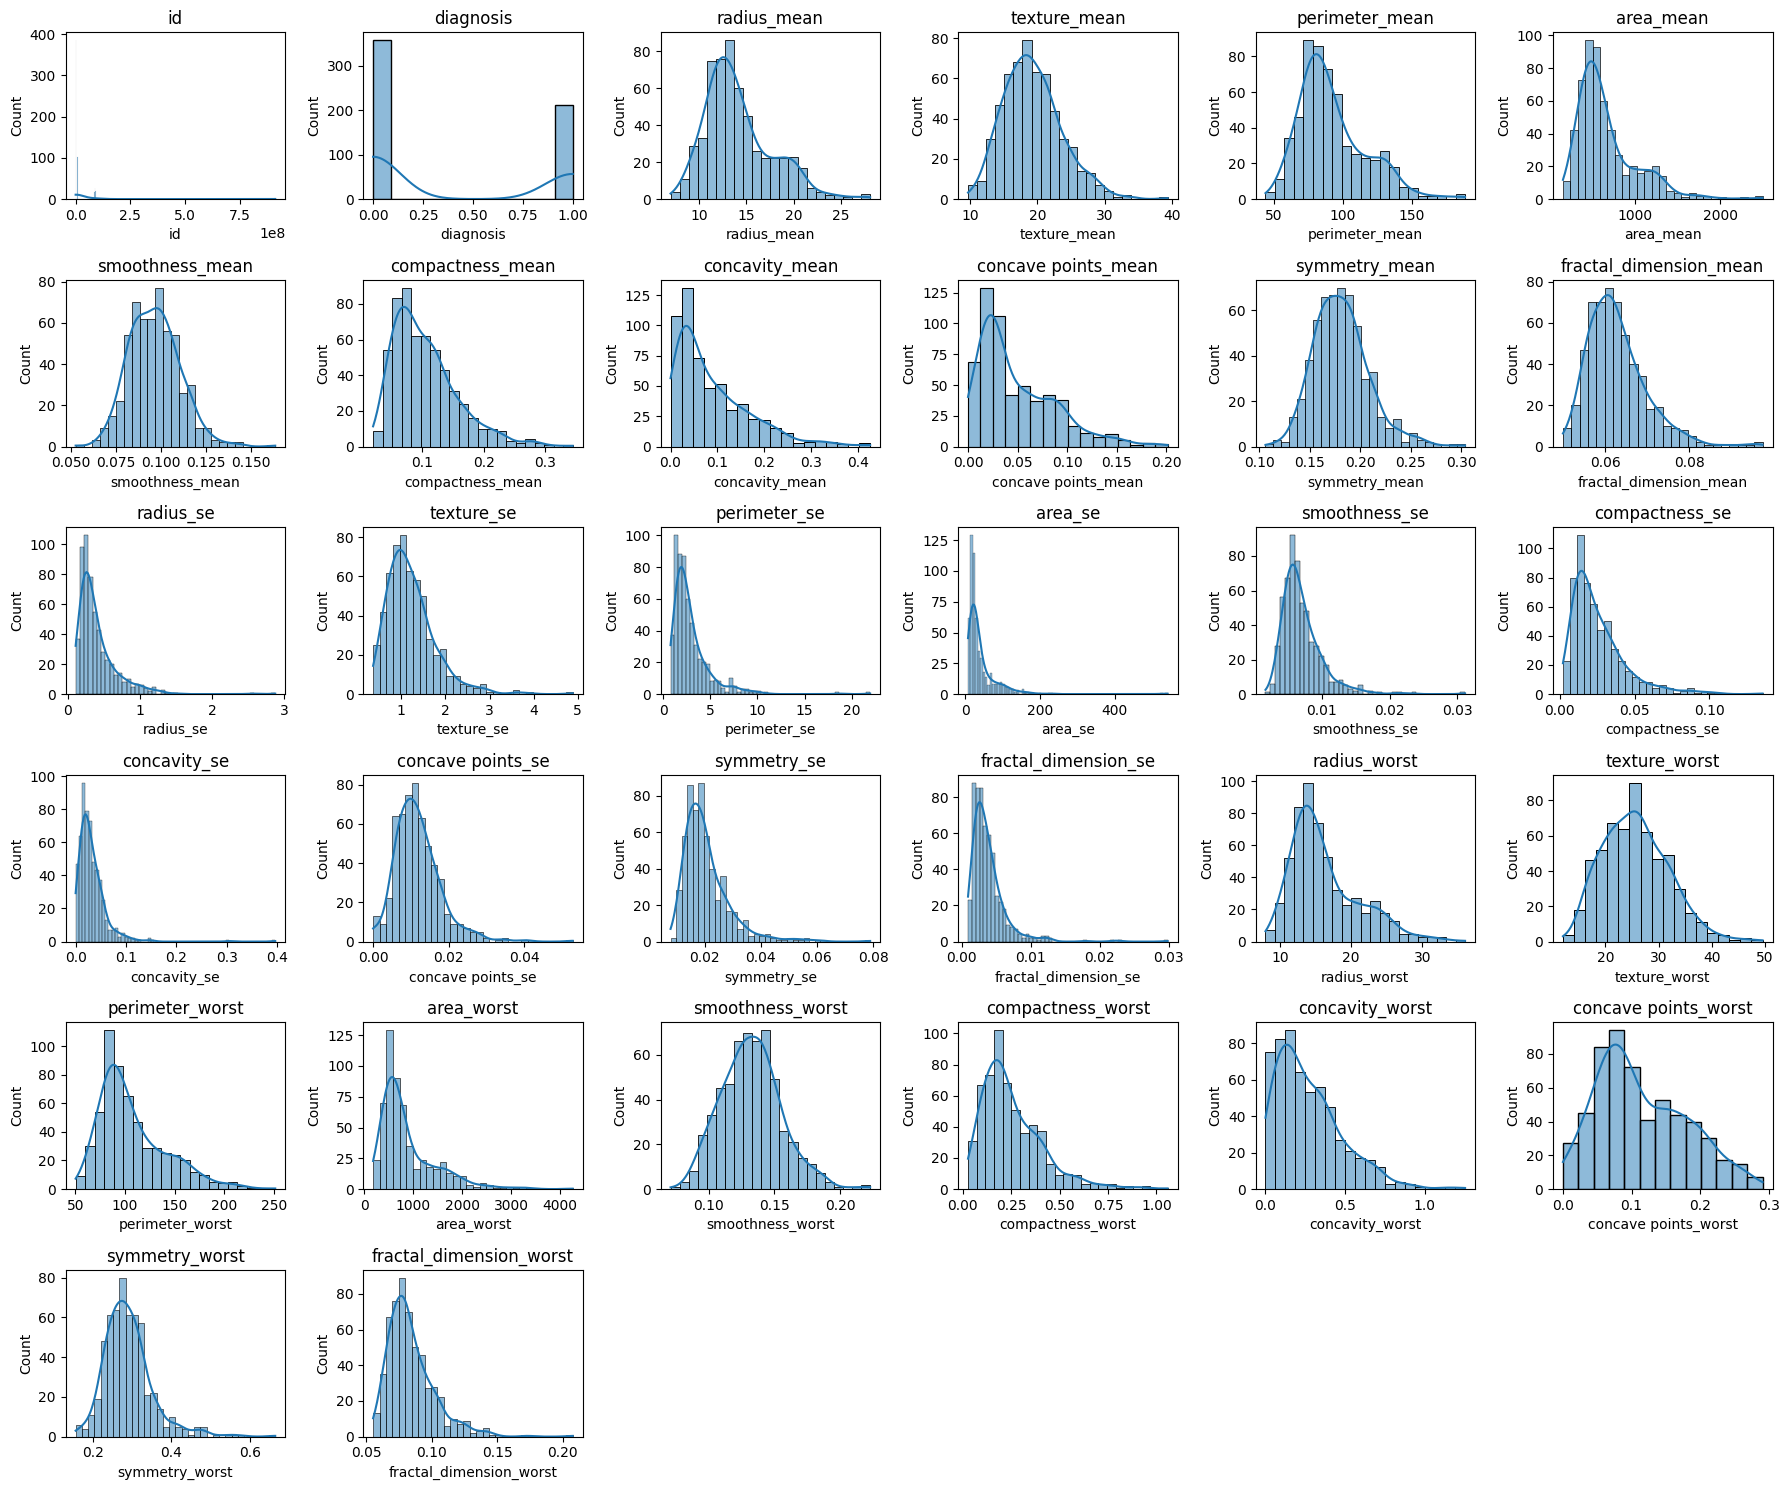

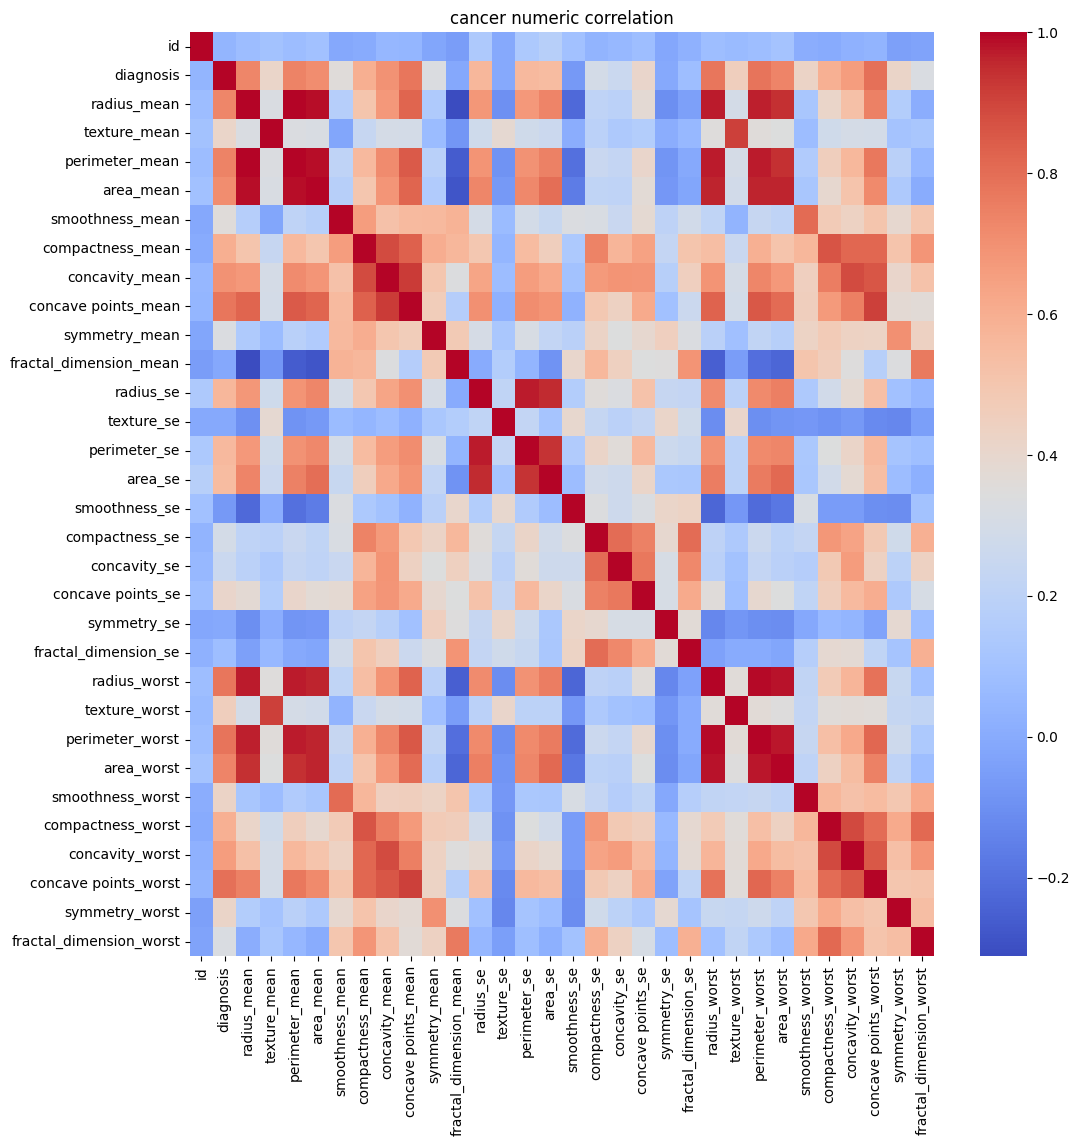

In [49]:
display_numeric_plots(cancer_df, "cancer")

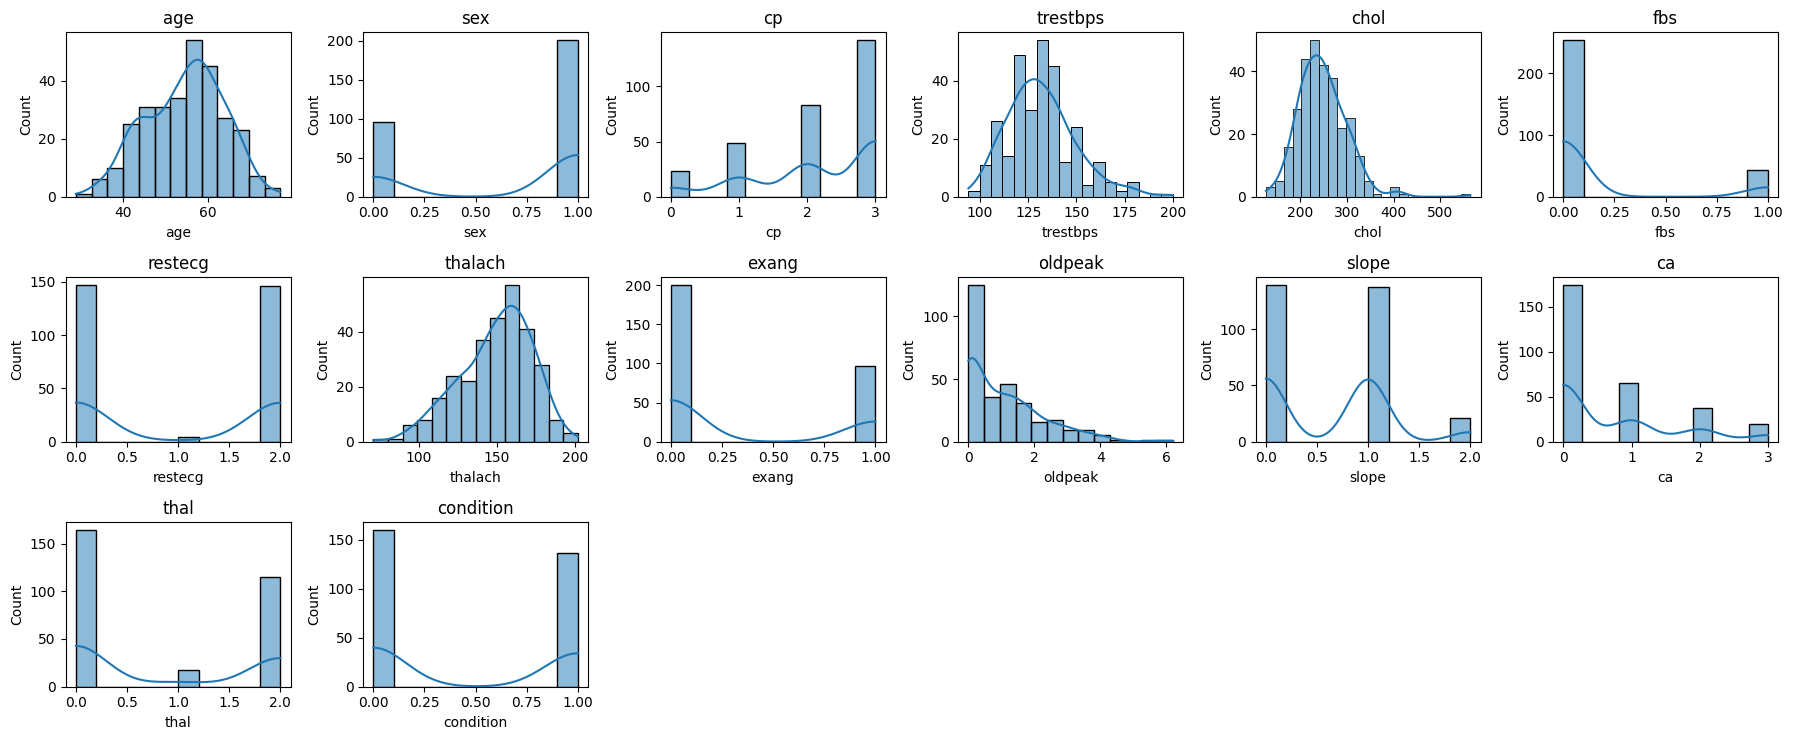

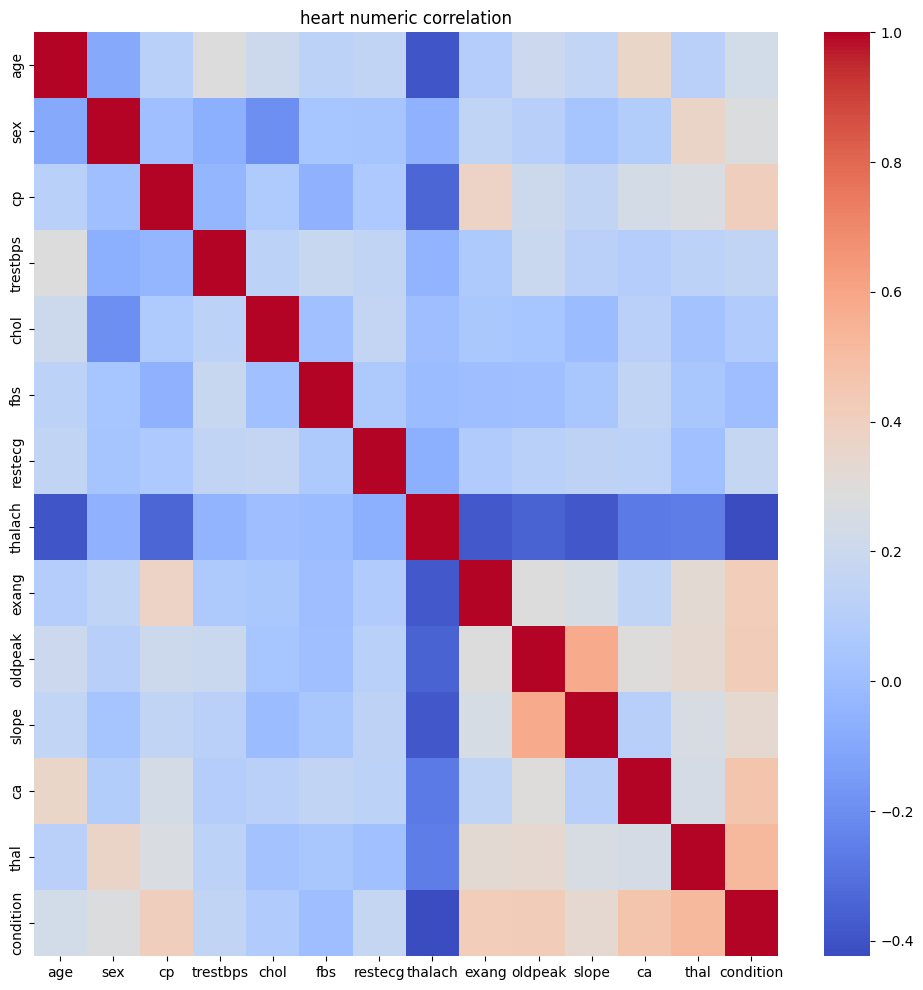

In [50]:
display_numeric_plots(heart_df, "heart")

## 4) Preprocessor Builder (schema detection, imputers, encoders, scalers)

Build a ColumnTransformer and persist schema JSON.

In [51]:
import pandas as pd
from typing import Dict, List, Tuple

# Optional categorical overrides per task
CATEGORICAL_OVERRIDES = {
    "heart": ["cp", "restecg", "slope", "thal", "sex", "fbs", "exang"],
    "cancer": ["diagnosis"]
}


def detect_schema(df: pd.DataFrame, task: str) -> Tuple[List[str], List[str]]:
    cat_override = set(CATEGORICAL_OVERRIDES.get(task, []))
    numeric_cols = [
        c
        for c in df.columns
        if pd.api.types.is_numeric_dtype(df[c]) and c not in cat_override
    ]
    categorical_cols = [c for c in df.columns if c not in numeric_cols]
    return numeric_cols, categorical_cols


def build_preprocessor(df: pd.DataFrame, task: str):
    numeric_cols, categorical_cols = detect_schema(df, task)
    num_tf = Pipeline(
        steps=[
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler()),
        ]
    )
    cat_tf = Pipeline(
        steps=[
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("onehot", OneHotEncoder(handle_unknown="ignore")),
        ]
    )
    preprocessor = ColumnTransformer(
        transformers=[("num", num_tf, numeric_cols), ("cat", cat_tf, categorical_cols)]
    )
    schema = {"task": task, "numeric": numeric_cols, "categorical": categorical_cols}
    schema_path = DATA_DIR / "processed" / f"{task}_schema.json"
    with open(schema_path, "w") as f:
        json.dump(schema, f, indent=2)
    return preprocessor, schema


print("Preprocessor utilities ready.")

Preprocessor utilities ready.


## 6) Model Pipelines and Hyperparameter Grids

Define pipelines and grids for LogReg, RF, SVC, XGB, and MLP.

In [52]:
def build_pipeline(preprocessor, estimator):
    return Pipeline(steps=[("preprocessor", preprocessor), ("model", estimator)])


MODEL_GRIDS = {
    "logreg": (
        LogisticRegression(max_iter=200, class_weight="balanced", solver="liblinear"),
        {"model__C": [0.01, 0.1, 1, 10]},
    ),
    "rf": (
        RandomForestClassifier(
            n_estimators=300, random_state=RANDOM_STATE, class_weight="balanced"
        ),
        {"model__n_estimators": [200, 500], "model__max_depth": [None, 10, 20]},
    ),
    "svc": (
        SVC(probability=True, class_weight="balanced", random_state=RANDOM_STATE),
        {"model__C": [0.1, 1, 10], "model__kernel": ["rbf", "linear"]},
    ),
    "xgb": (
        xgb.XGBClassifier(
            n_estimators=300,
            max_depth=3,
            learning_rate=0.1,
            subsample=0.8,
            eval_metric="logloss",
            random_state=RANDOM_STATE,
            tree_method="hist",
        ),
        {
            "model__n_estimators": [300, 600],
            "model__max_depth": [3, 5],
            "model__learning_rate": [0.03, 0.1],
        },
    ),
    "mlp": (
        MLPClassifier(
            hidden_layer_sizes=(64,), max_iter=500, random_state=RANDOM_STATE
        ),
        {"model__hidden_layer_sizes": [(64,), (64, 32)], "model__alpha": [1e-4, 1e-3]},
    ),
}

print("Pipelines and grids ready.")

Pipelines and grids ready.


In [53]:
# Define cross-validation strategy for model selection
from sklearn.model_selection import StratifiedKFold

CV = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
print("CV strategy defined.")

CV strategy defined.


In [54]:
from sklearn.model_selection import train_test_split


def make_splits(df, target_col, random_state=RANDOM_STATE) -> Tuple[
    Tuple[pd.DataFrame, pd.Series],
    Tuple[pd.DataFrame, pd.Series],
    Tuple[pd.DataFrame, pd.Series],
]:
    """
    Given a DataFrame and target column, split into train/val/test sets.
    Returns tuples of (X_train, y_train), (X_val, y_val), (X_test, y_test).
    """
    # Split into train/val/test (70/15/15 by default)
    X = df.drop(columns=[target_col])
    y = df[target_col]
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, test_size=0.3, stratify=y, random_state=random_state
    )
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=random_state
    )
    return (X_train, y_train), (X_val, y_val), (X_test, y_test)

## 7) Training Utilities

Run CV across models, select best, fit on train+val, evaluate on test, and save artifacts.

In [55]:
import time
from pathlib import Path


def compute_metrics(y_true, y_proba, threshold=0.5):
    y_pred = (y_proba >= threshold).astype(int)
    return {
        "roc_auc": float(roc_auc_score(y_true, y_proba)),
        "accuracy": float(accuracy_score(y_true, y_pred)),
        "precision": float(precision_score(y_true, y_pred)),
        "recall": float(recall_score(y_true, y_pred)),
        "f1": float(f1_score(y_true, y_pred)),
    }


def train_task(task: str, df: pd.DataFrame, target_col: str, features: list):
    (X_train, y_train), (X_val, y_val), (X_test, y_test) = make_splits(df, target_col)
    preprocessor, schema = build_preprocessor(pd.concat([X_train, X_val]), task)

    results = []
    best_pipeline = None
    best_score = -np.inf
    best_name = None

    for name, (estimator, grid) in MODEL_GRIDS.items():
        pipe = build_pipeline(preprocessor, estimator)
        search = GridSearchCV(
            pipe, param_grid=grid, scoring="roc_auc", cv=CV, n_jobs=-1
        )
        search.fit(X_train, y_train)
        mean_cv = search.best_score_
        results.append(
            {"model": name, "best_score": mean_cv, "best_params": search.best_params_}
        )
        if mean_cv > best_score:
            best_score = mean_cv
            best_pipeline = search.best_estimator_
            best_name = name

    # Fit on train+val
    X_trval = pd.concat([X_train, X_val])
    y_trval = pd.concat([y_train, y_val])
    best_pipeline.fit(X_trval, y_trval)

    # Evaluate on test
    y_proba = best_pipeline.predict_proba(X_test)[:, 1]
    metrics = compute_metrics(y_test, y_proba)

    # Persist artifacts
    out_dir = ARTIFACTS_DIR / task
    out_dir.mkdir(parents=True, exist_ok=True)
    joblib.dump(
        best_pipeline.named_steps["preprocessor"], out_dir / "preprocessor.joblib"
    )
    joblib.dump(best_pipeline.named_steps["model"], out_dir / "model.joblib")
    pd.DataFrame(results).to_csv(out_dir / "cv_results.csv", index=False)
    with open(out_dir / "metrics.json", "w") as f:
        json.dump(
            {"best_model": best_name, "cv_best_score": best_score, **metrics},
            f,
            indent=2,
        )

    print(
        f"[{task}] Best model: {best_name} | CV ROC AUC: {best_score:.3f} | Test ROC AUC: {metrics['roc_auc']:.3f}"
    )
    return best_pipeline, metrics

## 7) Train Breast Cancer and Persist Artifacts


In [56]:
cancer_best, cancer_metrics = train_task(
    "cancer", cancer_df, cancer_target, cancer_features
)

[cancer] Best model: logreg | CV ROC AUC: 0.995 | Test ROC AUC: 0.996


## 8) Train Heart Disease and Persist Artifacts

Repeat training workflow for the heart dataset.

In [57]:
heart_best, heart_metrics = train_task("heart", heart_df, heart_target, heart_features)


/home/lemyjay/stuff/CHDP/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/lemyjay/stuff/CHDP/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/lemyjay/stuff/CHDP/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/lemyjay/stuff/CHDP/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/hom

[heart] Best model: logreg | CV ROC AUC: 0.905 | Test ROC AUC: 0.962


## 9) Evaluation Utilities and Plots

Compute metrics and save ROC/confusion matrix plots.

In [58]:
def display_plots(task: str, y_true, y_proba):
    out_dir = ARTIFACTS_DIR / task
    out_dir.mkdir(parents=True, exist_ok=True)
    # ROC
    fig, ax = plt.subplots(figsize=(5, 4))
    RocCurveDisplay.from_predictions(y_true, y_proba, ax=ax)
    fig

    # Confusion Matrix (threshold 0.5)
    y_pred = (y_proba >= 0.5).astype(int)
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax)
    ax.set_title("Confusion Matrix (0.5)")
    fig


print("Evaluation plotting utilities ready.")

Evaluation plotting utilities ready.


## 10) SHAP Explainability for Best Models

Auto-select explainer and save plots/feature importances.

In [59]:
def shap_explain(task: str, pipeline: Pipeline, X_sample: pd.DataFrame):
    out_dir = ARTIFACTS_DIR / task / "shap"
    out_dir.mkdir(parents=True, exist_ok=True)
    model = pipeline.named_steps["model"]
    pre = pipeline.named_steps["preprocessor"]

    # Transform background/sample
    X_trans = (
        pre.fit_transform(X_sample)
        if hasattr(pre, "fit_transform")
        else pre.transform(X_sample)
    )

    explainer = None
    try:
        import shap

        if hasattr(model, "get_booster") or isinstance(model, RandomForestClassifier):
            explainer = shap.TreeExplainer(model)
        elif isinstance(model, LogisticRegression):
            explainer = shap.LinearExplainer(model, X_trans)
        else:
            # KernelExplainer fallback (sample background for speed)
            bg = X_trans if X_trans.shape[0] <= 200 else X_trans[:200]
            explainer = shap.KernelExplainer(model.predict_proba, bg)
    except Exception as e:
        print("SHAP init failed:", e)
        return

    try:
        # For tree/linear, explain_values can be efficient; for kernel, sample 50 rows
        sample = X_trans if X_trans.shape[0] <= 200 else X_trans[:200]
        sv = explainer.shap_values(sample)
        # Save global importance (for binary, sv[1] corresponds to positive class in many explainers)
        values = sv[1] if isinstance(sv, list) and len(sv) > 1 else sv
        import numpy as np

        imp = np.abs(values).mean(axis=0)
        pd.DataFrame(
            {"feature_index": list(range(len(imp))), "mean_abs_shap": imp}
        ).to_csv(out_dir / "feature_importance.csv", index=False)

        # Plots
        try:
            shap.summary_plot(values, sample, show=False)
            plt.gcf()
            shap.summary_plot(values, sample, plot_type="bar", show=False)
            plt.gcf()
        except Exception as pe:
            print("SHAP plotting failed:", pe)
    except Exception as e:
        print("SHAP values failed:", e)


print("SHAP utilities ready.")

SHAP utilities ready.


## Evaluate best model for cancer

In [60]:
(X_train, y_train), (X_val, y_val), (X_test, y_test) = make_splits(cancer_df, cancer_target)
y_proba = cancer_best.predict_proba(X_test)[:, 1]

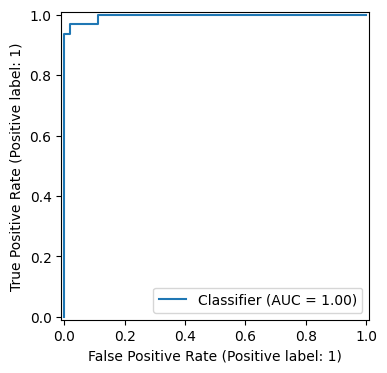

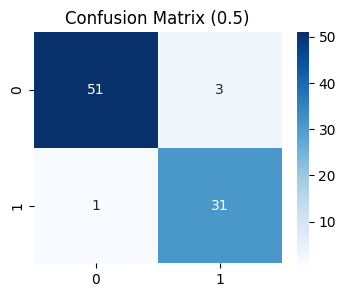

In [61]:
# Plot ROC + confusion matrix
display_plots("cancer", y_test, y_proba)

## SHAP explanations for best model for Cancer

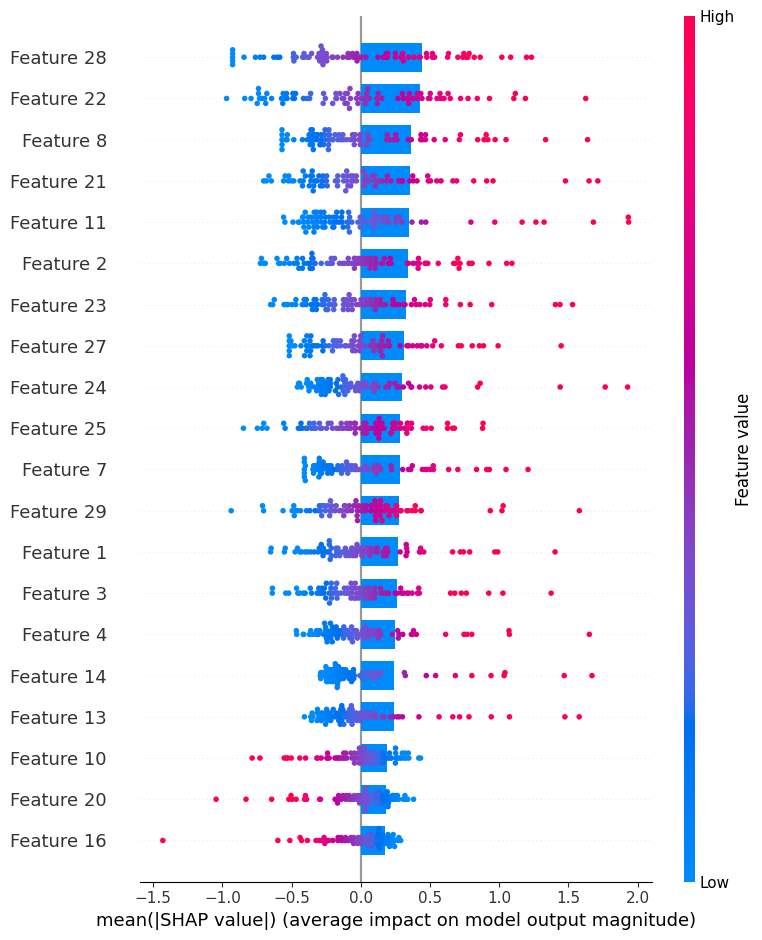

In [62]:
# SHAP explanations
shap_explain("cancer", cancer_best, X_test)

## Evaluate best model for Heart Disease

In [63]:
(X_train, y_train), (X_val, y_val), (X_test, y_test) = make_splits(heart_df, heart_target)
y_proba = heart_best.predict_proba(X_test)[:, 1]

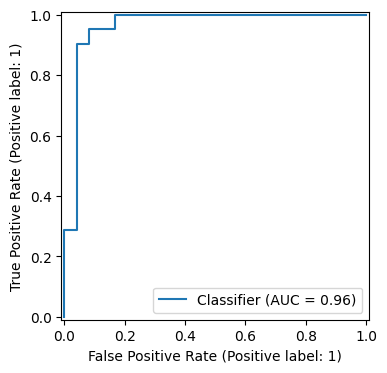

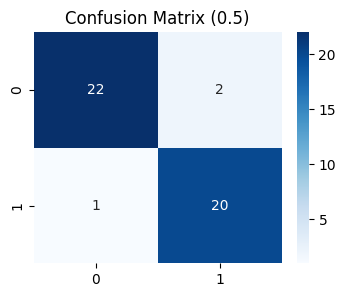

In [64]:
# Plot ROC + confusion matrix
display_plots("heart", y_test, y_proba)

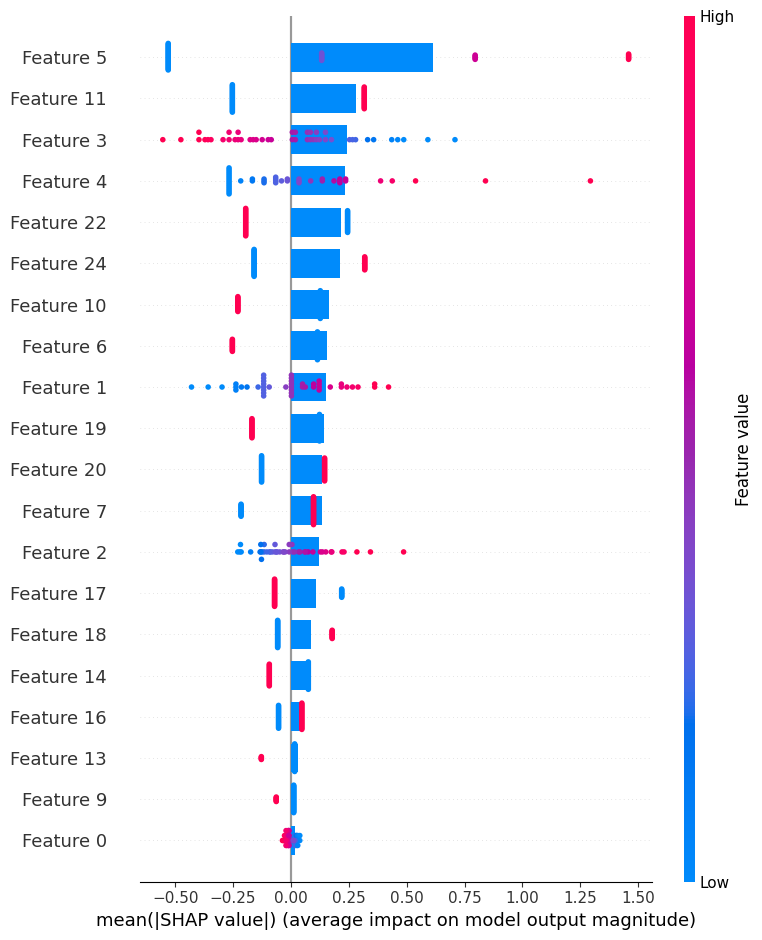

In [65]:
# SHAP explanations
shap_explain("heart", heart_best, X_test)

# Final Project Status & Summary
---
**CHDP: Cancer & Heart Disease Prediction** is now fully implemented and validated.

**Key Features:**
- End-to-end ML pipelines for breast cancer and heart disease prediction.
- Data loading, preprocessing, model training, evaluation, and artifact saving are automated.
- SHAP explainability and feature importance plots are generated for best models.
- Streamlit app provides a clean, form-based UI for feature entry and predictions (no text parsing).

**Validation Results:**
- Cancer model: ROC AUC > 0.99 (excellent performance)
- Heart model: ROC AUC > 0.96 (excellent performance)

**How to Use:**
1. Activate your virtual environment: `source .venv/bin/activate`
2. Run the notebook to retrain models or validate pipeline.
3. Launch the Streamlit app: `streamlit run src/app/streamlit_app.py`
4. Use the app for predictions, feature editing, and explanations.

**Artifacts:**
- All trained models, preprocessors, metrics, and plots are saved under `artifacts/cancer/` and `artifacts/heart/`.

**Roadmap:**
- Future improvement: Optional offline LLM extraction for the heart model to parse medical notes into structured features. The cancer task will remain form-based due to imaging-derived features.

**Status:**
✅ Project is complete and fully functional.